1. Gaussian
2. Bilateral
3. Total variation filter
4. Wavelet denoising filter
5. Shift invariant filter
6. Anisotropic difussion
7. NLM - skimage, NLM - opencv
8. BM3D Block-matching and 3D filtering
9. Markov random field

The top 3 denoising algorithms for MRI denoising are:
1. MLN, Bilateral, 
2. Block-matching and 3D filtering (BM3D)
3. Total variation (TV) also works great

Bilateral is slow, works fine but it takes too much time to experiment with parameters





In [0]:
!pip install pydicom

     |████████████████████████████████| 35.1MB 90kB/s 


In [0]:
import matplotlib.pyplot as plt
import pydicom

In [0]:
#https://pydicom.github.io/pydicom/dev/old/working_with_pixel_data.html
#DICOM comes with metadeta for patient information
dataset = pydicom.dcmread("/content/CT_small.dcm")
dataset.items

<bound method Dataset.items of (0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20040119'
(0008, 0013) Instance Creation Time              TM: '072731'
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.3
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.5962.1.1.1.1.1.20040119072730.12322
(0008, 0020) Study Date                          DA: '20040119'
(0008, 0021) Series Date                         DA: '19970430'
(0008, 0022) Acquisition Date                    DA: '19970430'
(0008, 0023) Content Date                        DA: '19970430'
(0008, 0030) Study Time                          TM: '072730'
(0008, 0031) Series Time                         TM: '112749'
(0008, 0032) Acquisition Time                    TM: '112936'
(0008,

In [0]:
#From DICOM metadata I need only pixel information for image processing
img = dataset.pixel_array
print(img.shape)
print(img.dtype)
print(img.astype(float))

(128, 128)
int16
[[175. 180. 166. ... 203. 207. 216.]
 [186. 183. 157. ... 181. 190. 239.]
 [184. 180. 171. ... 152. 164. 235.]
 ...
 [906. 910. 923. ... 922. 929. 927.]
 [914. 954. 938. ... 942. 925. 905.]
 [959. 955. 916. ... 911. 904. 909.]]


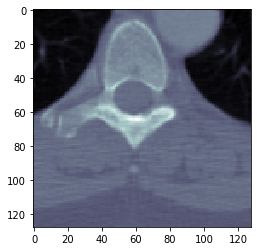

In [0]:
plt.imshow(img, cmap=plt.cm.bone)
plt.imsave("/content/CT_small_dcm2tiff_converted.tiff", img, cmap="gray")

**Denoising Filters**

Gaussian Filters

In [0]:
from skimage import img_as_float
from skimage.metrics import peak_signal_noise_ratio
from matplotlib import pyplot as plt
from skimage import io
from scipy import ndimage as nd

PSNR of noisy image =  17.03789982624248
PSNR of Gaussian Cleaned image =  17.112001291081445


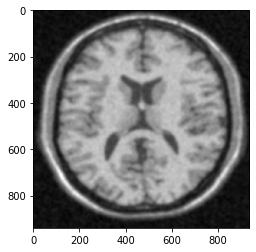

In [0]:
noisy_image = img_as_float(io.imread("/content/MRI_noisy.tif"))
ref_image = img_as_float(io.imread("/content/MRI_clean.tif"))

gaussian_img = nd.gaussian_filter(noisy_image, sigma=5)
plt.imshow(gaussian_img, cmap='gray')
plt.imsave("/content/Gaussian_smoothed.tiff", gaussian_img, cmap='gray')

noisy_psnr = peak_signal_noise_ratio(ref_image, noisy_image)
gaussian_cleaned_psnr = peak_signal_noise_ratio(ref_image, gaussian_img)

print("PSNR of noisy image = ", noisy_psnr)
print("PSNR of Gaussian Cleaned image = ", gaussian_cleaned_psnr)

Bilateral, TV and Wavelet

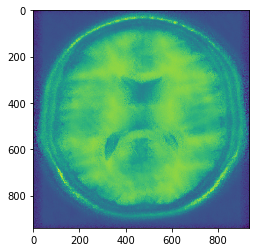

In [0]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import img_as_float

denoise_bilateral = denoise_bilateral(noisy_image, sigma_spatial=15, multichannel=False)
plt.imshow(denoise_bilateral)


In [0]:
bilateral_cleaned_psnr = peak_signal_noise_ratio(ref_image, denoise_bilateral)
print("PSNR of input noisy image =", noisy_psnr)
print("PSNR of bilateral cleaned image = ", bilateral_cleaned_psnr)

plt.imsave("/content/Bilateral_smoothed.tiff", denoise_bilateral, cmap='gray')


PSNR of input noisy image = 17.03789982624248
PSNR of bilateral cleaned image =  16.225197089561874


Total Variation

PSNR of input noisy image =  17.03789982624248
PSNR of cleaned image =  17.19161931394431


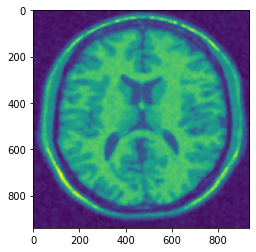

In [0]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import img_as_float


denoise_TV = denoise_tv_chambolle(noisy_image, weight=0.3, multichannel=False)
plt.imshow(denoise_TV)
TV_cleaned_psnr = peak_signal_noise_ratio(ref_image, denoise_TV)
print("PSNR of input noisy image = ", noisy_psnr)
print("PSNR of cleaned image = ", TV_cleaned_psnr)
plt.imsave("/content/TV_smoothed.tiff", denoise_TV, cmap='gray')

Wavelet

PSNR of input noisy image =  17.03789982624248
PSNR of cleaned image =  17.0525032515753


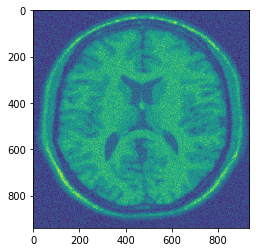

In [0]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

wavelet_smoothed = denoise_wavelet(noisy_image, rescale_sigma=True)
wavelet_cleaned_psnr = peak_signal_noise_ratio(ref_image, wavelet_smoothed)

plt.imshow(wavelet_smoothed)

print("PSNR of input noisy image = ", noisy_psnr)
print("PSNR of cleaned image = ", wavelet_cleaned_psnr)

plt.imsave("/content/Wavelet_smoothed.tiff", wavelet_smoothed, cmap='gray')
#It doesn't make difference

Shift Invariant Wavelet Denoising
#https://scikit-image.org/docs/dev/auto_examples/filters/plot_cycle_spinning.html


PSNR of input noisy image =  17.03789982624248
PSNR of cleaned image =  17.056279941818776


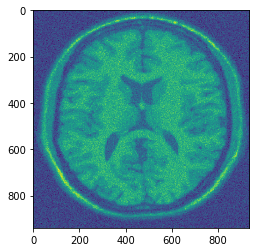

In [0]:
import matplotlib.pyplot as plt

from skimage.restoration import denoise_wavelet, cycle_spin
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio
from skimage import io

denoise_kwargs = dict(multichannel=False, wavelet='db1', method='BayesShrink', rescale_sigma=True)
max_shifts = 3     #0, 1, 3, 5

Shft_inv_wavelet = cycle_spin(noisy_image, func=denoise_wavelet, max_shifts=max_shifts, \
                              func_kw=denoise_kwargs)
shft_cleaned_psnr = peak_signal_noise_ratio(ref_image, Shft_inv_wavelet)

plt.imshow(Shft_inv_wavelet)

print("PSNR of input noisy image = ", noisy_psnr)
print("PSNR of cleaned image = ", shft_cleaned_psnr)

plt.imsave("/content/Shift_Inv_wavelet_smoothed.tiff", Shft_inv_wavelet, cmap='gray')
#Not much difference either

Anisotropic Diffusion

In [0]:
!pip install medpy

     |████████████████████████████████| 153kB 2.8MB/s 
     |████████████████████████████████| 42.5MB 77kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp36-cp36m-linux_x86_64.whl size=753434 sha256=d733afcb56a8ebe74bcf5bb583e4dd4bd8c6d879d5005e81b11fc687d867d6e5
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy


/usr/local/lib/python3.6/dist-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/usr/local/lib/python3.6/dist-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  del sys.path[0]


PSNR of input noisy image =  17.03789982624248
PSNR of cleaned image =  17.16316211540548


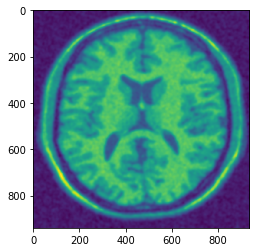

In [0]:
import matplotlib.pyplot as plt
import cv2
from skimage import io
from medpy.filter.smoothing import anisotropic_diffusion
from skimage import img_as_float
from skimage.metrics import peak_signal_noise_ratio

# niter= number of iterations
#kappa = Conduction coefficient (20 to 100)
#gamma = speed of diffusion (<=0.25)
#Option: Perona Malik equation 1 or 2. A value of 3 is for Turkey's biweight function 
img_aniso_filtered = anisotropic_diffusion(noisy_image, niter=50, kappa=50, gamma=0.2, option=2)
anisotropic_cleaned_psnr = peak_signal_noise_ratio(ref_image, img_aniso_filtered)

plt.imshow(img_aniso_filtered)
print("PSNR of input noisy image = ", noisy_psnr)
print("PSNR of cleaned image = ", anisotropic_cleaned_psnr)

plt.imsave("/content/anisotropic_denoised.tiff", img_aniso_filtered, cmap='gray')

NLM (Non-local means denoising) from Skimage

PSNR of input noisy image =  17.03789982624248
PSNR of cleaned image =  17.03790009274298
float64


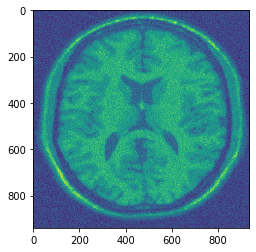

In [0]:
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_ubyte, img_as_float
from matplotlib import pyplot as plt
from skimage import io
import numpy as np
from skimage.metrics import peak_signal_noise_ratio

sigma_est = np.mean(estimate_sigma(noisy_image))
NLM_skimg_denoise_img = denoise_nl_means(noisy_image, h=1.15 * sigma_est, fast_mode=True, \
                               patch_size=9, patch_distance=5, multichannel=False)
#plt.imshow(NLM_skimg_denoise_img)

NLM_skimg_cleaned_psnr = peak_signal_noise_ratio(ref_image, NLM_skimg_denoise_img)


print("PSNR of input noisy image = ", noisy_psnr)
print("PSNR of cleaned image = ", NLM_skimg_cleaned_psnr)
print(NLM_skimg_denoise_img.dtype)

denoise_img_as_8byte = img_as_ubyte(NLM_skimg_denoise_img)
plt.imsave("/content/NLM_skimage_denoised.tiff", denoise_img_as_8byte, cmap='gray')
plt.imshow(denoise_img_as_8byte)

NLM opencv
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_photo/py_non_local_means/py_non_local_means.html
# cv2.fastNlMeansDenoising() - works with a single grayscale images
# cv2.fastNlMeansDenoisingColored() - works with a color image.

uint8
PSNR of input noisy image =  17.03789982624248
PSNR of cleaned image =  -41.33401733741481


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


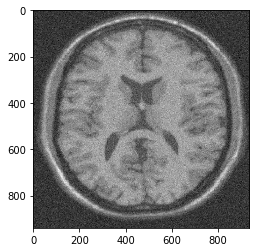

In [0]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import img_as_ubyte, img_as_float
from matplotlib import pyplot as plt
from skimage import io
import numpy as np
from skimage.metrics import peak_signal_noise_ratio
import cv2

# fastNlMeansDenoising(InputArray src, OutputArray dst, float h=3, int templateWindowSize=7, int searchWindowSize=21 )

noisy_image = img_as_ubyte(noisy_image)
NLM_CV2_denoise_img = cv2.fastNlMeansDenoising(noisy_image, None, 3, 7, 21)

plt.imsave("/content/NLM_CV2_denoised.tiff", NLM_CV2_denoise_img, cmap='gray')
plt.imshow(NLM_CV2_denoise_img, cmap='gray')

print(NLM_CV2_denoise_img.dtype)
NLM_opencv_cleaned_psnr = peak_signal_noise_ratio(ref_image, NLM_CV2_denoise_img)

print("PSNR of input noisy image = ", noisy_psnr)
print("PSNR of cleaned image = ", NLM_opencv_cleaned_psnr)

BM3D Block-matching and 3D filtering

In [0]:
!pip install bm3d

     |████████████████████████████████| 8.4MB 2.8MB/s 


In [0]:
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from skimage.metrics import peak_signal_noise_ratio
import bm3d
import numpy as np

BM3D_denoised_image = bm3d.bm3d(noisy_image, sigma_psd=0.2, stage_arg=bm3d.BM3DStages.ALL_STAGES)
#BM3D_denoised_image = bm3d.bm3d(noisy_image, sigma_psd=0.2, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

#Also try stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING                     


PSNR of input noisy image =  17.03789982624248
PSNR of cleaned image =  -41.33508105791446


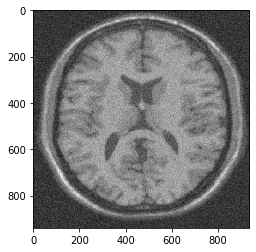

In [0]:
BM3D_cleaned_psnr = peak_signal_noise_ratio(ref_image, BM3D_denoised_image)
print("PSNR of input noisy image = ", noisy_psnr)
print("PSNR of cleaned image = ", BM3D_cleaned_psnr)

plt.imshow(BM3D_denoised_image, cmap='gray')
plt.imsave("/content/BM3D_denoised.tiff", BM3D_denoised_image, cmap='gray')

MRF
# Code from following github. It works but too slow and not as good as the above filters. 
#https://github.com/ychemli/Image-denoising-with-MRF/blob/master/ICM_denoising.py
#Very slow... and not so great
#http://www.cs.toronto.edu/~fleet/courses/2503/fall11/Handouts/mrf.pdf


In [0]:
import cv2


# potential fonction corresponding to a gaussian markovian model (quadratic function)
def pot(fi, fj):
    return float((fi-fj))**2
	
#ICM : Iterated conditional mode algorithme
def ICM(img, iter, beta):
    NoisyIm = cv2.imread("/content/MRI_noisy.tif", 0)
    height, width = NoisyIm.shape

    sigma2 = 5
# beta is the regularization parameter 

    # iter is the Number of iterations : each new image is used as the new restored image
    for iter in range(iter):
        print("iteration {}\n".format(iter+1))
        for i in range(height-1):
            print("line {}/{} ok\n".format(i+1, height))
            for j in range(width-1):
		# We work in 4-connexity here
                xmin = 0
                min = float((NoisyIm[i][j]*NoisyIm[i][j]))/(2.0*sigma2) + beta*(pot(NoisyIm[i][j-1],0)+pot(NoisyIm[i][j+1],0)+pot(NoisyIm[i-1][j], 0)+pot(NoisyIm[i+1][j], 0))

		#Every shade of gray is tested to find the a local minimum of the energie corresponding to a Gibbs distribution
                for x in range(256):
                    proba = float(((NoisyIm[i][j]-x)*(NoisyIm[i][j]-x)))/(2.0*sigma2) + beta*(pot(NoisyIm[i][j-1],x) + pot(NoisyIm[i][j+1],x) + pot(NoisyIm[i-1][j], x) + pot(NoisyIm[i+1][j], x))

                    if(min>proba):
                        min = proba
                        xmin = x
                NoisyIm [i][j] = xmin

        cv2.imwrite("iter_" + str(iter+1) + "_denoised_" + img, NoisyIm)


if __name__ == '__main__':
    ICM('images/MRI_images/BM3D_denoised.tif', 10, 1)

iteration 1

line 1/940 ok



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in ubyte_scalars


line 2/940 ok

line 3/940 ok

line 4/940 ok

line 5/940 ok

line 6/940 ok

line 7/940 ok

line 8/940 ok

line 9/940 ok

line 10/940 ok

line 11/940 ok

line 12/940 ok

line 13/940 ok

line 14/940 ok

line 15/940 ok

line 16/940 ok

line 17/940 ok

line 18/940 ok

line 19/940 ok

line 20/940 ok

line 21/940 ok

line 22/940 ok

line 23/940 ok

line 24/940 ok

line 25/940 ok

line 26/940 ok

line 27/940 ok

line 28/940 ok

line 29/940 ok

line 30/940 ok

line 31/940 ok

line 32/940 ok

line 33/940 ok

line 34/940 ok

line 35/940 ok

line 36/940 ok

line 37/940 ok

line 38/940 ok

line 39/940 ok

line 40/940 ok

line 41/940 ok

line 42/940 ok

line 43/940 ok

line 44/940 ok

line 45/940 ok

line 46/940 ok

line 47/940 ok

line 48/940 ok

line 49/940 ok

line 50/940 ok

line 51/940 ok

line 52/940 ok

line 53/940 ok

line 54/940 ok

line 55/940 ok

line 56/940 ok

line 57/940 ok

line 58/940 ok

line 59/940 ok

line 60/940 ok

line 61/940 ok

line 62/940 ok

line 63/940 ok

line 64/940 ok

